In [1]:
import numpy as np

import cv2
import glob
import os

from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D,GlobalAveragePooling2D,Activation
from keras.callbacks import ModelCheckpoint  

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/ryosuke/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
def process_image_with_label(image_file_names, color = "red"):
    image_array = []
    labels = []
    desired_size = (128,128)
    color_label = {"red":0, "yellow":1, "green":2, "off":3}
    label = color_label.get(color)

    for image_file_name in image_file_names:
        image = cv2.imread(image_file_name)
        resized_image = cv2.resize(image, desired_size, cv2.INTER_LINEAR)
        resized_image = resized_image.astype('float32')/255
        image_array.append(resized_image)
        labels.append(label)
    return np.array(image_array),np.array(labels)

In [3]:
def get_images_with_labels(data_dir):
    images = []
    labels = []
    
    red_images, red_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"*_red.png")), color = "red")
    yellow_images, yellow_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"*_yellow.png")), color = "yellow")
    green_images, green_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"*_green.png")), color = "green")
    off_images, off_labels = process_image_with_label(glob.glob(os.path.join(data_dir,"*_off.png")), color = "off")
    
    images = np.concatenate((red_images,yellow_images, green_images, off_images))
    labels = np.concatenate((red_labels, yellow_labels, green_labels, off_labels))
    return np.array(images),np.array(labels)

In [4]:
train_images, train_labels = get_images_with_labels("data/cropped_data/train_margin10")
additional_images, additional_labels = get_images_with_labels("data/cropped_data/additional_train_margin10")
test_images, test_labels = get_images_with_labels("data/cropped_data/test_margin10")

In [5]:
# Concatenate training data with additional training data
train_images = np.concatenate((train_images, additional_images))
train_labels = np.concatenate((train_labels, additional_labels))

In [6]:
# One-hot encode the labels
NUM_CLASSES = 4
train_labels_oh = np_utils.to_categorical(train_labels, NUM_CLASSES)
additional_labels_oh = np_utils.to_categorical(additional_labels,  NUM_CLASSES)
test_labels_oh = np_utils.to_categorical(test_labels,  NUM_CLASSES)

In [7]:
# Train, Validation split
X_train, X_val, y_train, y_val = train_test_split(
                train_images,train_labels_oh,train_size = 0.75, random_state = 402)
assert(X_train.shape[0] == y_train.shape[0])
assert(X_val.shape[0] == y_val.shape[0])

In [8]:
NUM_CLASSES = 4
model = Sequential()

# Block1
model.add(Conv2D(16, (2, 2), padding = 'same', input_shape =train_images[0].shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# Block2
model.add(Conv2D(32, (2, 2), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# Block3
model.add(Conv2D(64, (2, 2), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# Block4
# model.add(Conv2D(64, (2, 2), padding = 'same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())
# Fully connected layers
model.add(Dense(30))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
__________

In [9]:
checkpointer =  ModelCheckpoint(filepath = 'saved_models/weights128_test.hdf5',
                              verbose = 1, save_best_only = True)
history = model.fit(X_train, y_train,
                    batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_val, y_val),callbacks = [checkpointer])


Train on 7212 samples, validate on 2404 samples
Epoch 1/20
7212/7212 [==============================] - 7s - loss: 1.0850 - acc: 0.5326 - val_loss: 1.0861 - val_acc: 0.5537
Epoch 2/20
7212/7212 [==============================] - 4s - loss: 1.0228 - acc: 0.5513 - val_loss: 1.0602 - val_acc: 0.5628
Epoch 3/20
7212/7212 [==============================] - 4s - loss: 0.8299 - acc: 0.6812 - val_loss: 0.6132 - val_acc: 0.8170
Epoch 4/20
7212/7212 [==============================] - 4s - loss: 0.5413 - acc: 0.8245 - val_loss: 0.5202 - val_acc: 0.8432
Epoch 5/20
7212/7212 [==============================] - 4s - loss: 0.5012 - acc: 0.8365 - val_loss: 0.5116 - val_acc: 0.8457
Epoch 6/20
7212/7212 [==============================] - 4s - loss: 0.4923 - acc: 0.8417 - val_loss: 0.4899 - val_acc: 0.8415
Epoch 7/20
7212/7212 [==============================] - 4s - loss: 0.4804 - acc: 0.8453 - val_loss: 0.4847 - val_acc: 0.8511
Epoch 8/20
7212/7212 [==============================] - 4s - loss: 0.4725 - a

In [10]:
# serialize model to JSON
model_json = model.to_json()
with open("saved_models/model128_test.json", "w") as json_file:
    json_file.write(model_json)

### Visualize Loss and Accuracy

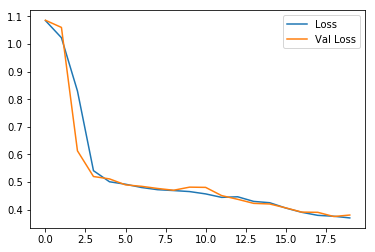

In [11]:
#Visualize loss
plt.plot(history.history["loss"],label = "Loss")
plt.plot(history.history["val_loss"], label ="Val Loss")
plt.legend()

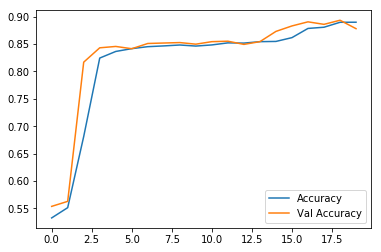

In [12]:
# Visualize accuracy
plt.plot(history.history["acc"],label = "Accuracy")
plt.plot(history.history["val_acc"], label ="Val Accuracy")
plt.legend()

### Test data Evaluation

In [13]:
X_test, y_test = test_images, test_labels_oh
prediction = model.predict_classes(X_test, verbose = 0)

In [14]:
score = model.evaluate(X_test,y_test)
print(score)
print("Accuracy:{:.3f}".format(score[1]))

13376/13418 [============================>.] - ETA: 0s[0.20421407161537686, 0.94544641527196371]
Accuracy:0.945


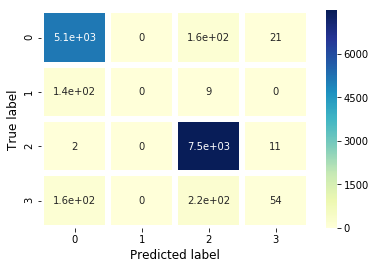

In [15]:
#Confusion Matrix
sns.heatmap(confusion_matrix(test_labels,prediction),cmap="YlGnBu",linewidth = 5, annot= True)
plt.xlabel("Predicted label", fontsize = 12)
plt.ylabel("True label", fontsize = 12)

## Udacity Traffic Light Data

In [16]:
def get_images_with_labels_udacity():
    # red_image_file = glob.glob("udacity_data/*/red/*.jpg")
    # yellow_image_file = glob.glob("udacity_data/*/yellow/*.jpg")
    # green_image_file = glob.glob("udacity_data/*/green/*.jpg")
    red_image_file = glob.glob("data/udacity_data/bag_dump_just_traffic_light/red/*.jpg")
    yellow_image_file = glob.glob("data/udacity_data/bag_dump_just_traffic_light/yellow/*.jpg")
    green_image_file = glob.glob("data/udacity_data/bag_dump_just_traffic_light/green/*.jpg")
    nolight_image_file = glob.glob("data/udacity_data/bag_dump_just_traffic_light/nolight/*.jpg")
      
    red_images,red_labels = process_image_with_label(red_image_file,color = "red")
    yellow_images,yellow_labels = process_image_with_label(yellow_image_file,color = "yellow")
    green_images,green_labels = process_image_with_label(green_image_file,color = "green")
    off_images,off_labels = process_image_with_label(nolight_image_file,color = "off")
    
    images = np.concatenate((red_images,yellow_images, green_images, off_images))
    labels = np.concatenate((red_labels, yellow_labels, green_labels, off_labels))

    return np.array(images),np.array(labels)

In [17]:
udacity_images, udacity_labels = get_images_with_labels_udacity()

In [18]:
label_count = 4
# One-hot encode the labels
udacity_labels_oh = np_utils.to_categorical(udacity_labels, label_count)

In [19]:
pred_udacity = model.predict_classes(udacity_images, verbose = 0)

In [20]:
score_udacity = model.evaluate(udacity_images,udacity_labels_oh)

544/704 [======================>.......] - ETA: 0s

In [21]:
print(score_udacity)
print("Accuracy:{:.3f}".format(score_udacity[1]))

[1.2259510294957594, 0.37642045454545453]
Accuracy:0.376


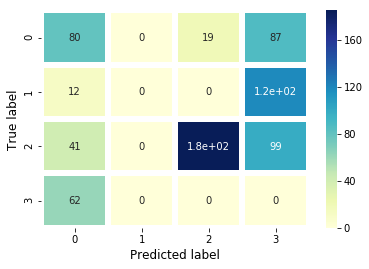

In [22]:
sns.heatmap(confusion_matrix(udacity_labels,pred_udacity),cmap="YlGnBu",linewidth = 5, annot= True)
plt.xlabel("Predicted label", fontsize = 12)
plt.ylabel("True label", fontsize = 12)